# 06 - Modeling: Battle Outcome Prediction

**Purpose**: Build predictive models for technical rigor scoring.

**Goal**: Predict battle outcomes based on deck composition alone.

**Models to Try**:
1. Logistic Regression (baseline)
2. Random Forest (feature importance insights)
3. XGBoost (likely best performance)

**Key Metrics**:
- Accuracy
- Precision/Recall
- ROC-AUC
- Feature importance (for insights!)

In [13]:
import sys, os, pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import xgboost as xgb

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, os.path.join(PROJECT_ROOT, 'src'))

from visualization import setup_presentation_style
setup_presentation_style()

✓ Presentation style configured


In [14]:
# Import GPU detection utilities
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, os.path.join(PROJECT_ROOT, 'src'))

from system_utils import get_xgboost_params, print_cuda_info, configure_environment_for_ml

# Configure ML environment (auto-detects GPU)
ml_config = configure_environment_for_ml(verbose=True)


⚙️  Environment Configuration:
🖥️  Device: GPU (CUDA)
🧵 DuckDB Threads: 24
⚡ XGBoost: GPU
🔬 scikit-learn: CUDA



In [15]:
# Load engineered features from notebook 05
features_path_candidates = [
    os.path.join(PROJECT_ROOT, 'artifacts', 'model_features.parquet'),
    os.path.join(PROJECT_ROOT, 'notebooks', 'artifacts', 'model_features.parquet'),
]

features_path = next((path for path in features_path_candidates if os.path.exists(path)), None)

if features_path is None:
    print("❌ ERROR: model_features.parquet not found!")
    print("   Please run Notebook 05 first to create features.")
    print("   Searched locations:")
    for path in features_path_candidates:
        print(f"     - {path}")
    raise FileNotFoundError("model_features.parquet not found in expected locations")

features = pd.read_parquet(features_path)

print(f"✓ Loaded {len(features):,} battles with {len(features.columns)} features")
print(f"  Source: {features_path}")
print(f"  Memory usage: {features.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

✓ Loaded 1,678,990 battles with 87 features
  Source: c:\Users\Danny\Documents\GitHub\HeHeHaHa_DataRoyale\notebooks\artifacts\model_features.parquet
  Memory usage: 1960.1 MB


In [16]:
# Restructure data for binary classification (vectorized for performance)
# Each battle becomes 2 rows: one from winner's perspective (outcome=1), one from loser's perspective (outcome=0)

print("Restructuring data for binary classification...")

# Get numeric columns only
numeric_cols = features.select_dtypes(include=[np.number]).columns.tolist()

# Create winner perspective (outcome = 1)
winner_data = features[numeric_cols].copy()
winner_data = winner_data.rename(columns=lambda x: x.replace('winner.', 'player.').replace('loser.', 'opponent.'))
winner_data = winner_data.rename(columns={
    'winner_beatdown': 'player_beatdown', 'winner_cycle': 'player_cycle',
    'winner_spell_heavy': 'player_spell_heavy', 'winner_building_heavy': 'player_building_heavy',
    'loser_beatdown': 'opponent_beatdown', 'loser_cycle': 'opponent_cycle',
    'loser_spell_heavy': 'opponent_spell_heavy', 'loser_building_heavy': 'opponent_building_heavy'
})
winner_data['outcome'] = 1

# Create loser perspective (outcome = 0)
loser_data = features[numeric_cols].copy()
loser_data = loser_data.rename(columns=lambda x: x.replace('loser.', 'player.').replace('winner.', 'opponent.'))
loser_data = loser_data.rename(columns={
    'loser_beatdown': 'player_beatdown', 'loser_cycle': 'player_cycle',
    'loser_spell_heavy': 'player_spell_heavy', 'loser_building_heavy': 'player_building_heavy',
    'winner_beatdown': 'opponent_beatdown', 'winner_cycle': 'opponent_cycle',
    'winner_spell_heavy': 'opponent_spell_heavy', 'winner_building_heavy': 'opponent_building_heavy'
})
# Flip sign of difference features for loser perspective
diff_cols = ['trophy_diff', 'elixir_diff', 'card_level_diff', 'spell_diff', 'crown_diff']
for col in diff_cols:
    if col in loser_data.columns:
        loser_data[col] = -loser_data[col]
loser_data['outcome'] = 0

# Combine both perspectives
model_data = pd.concat([winner_data, loser_data], ignore_index=True)

# Select feature columns (exclude outcome and any target-related columns)
# CRITICAL: Exclude 'crowns' as it's the battle outcome (data leakage!)
exclude_patterns = ['outcome', 'trophyChange', '.tag', '.clan', 'kingTower', 'princessTowers', 'crowns', 'crown']
feature_cols = [col for col in model_data.columns 
                if col != 'outcome' and not any(pattern in col for pattern in exclude_patterns)]

# Prepare X and y
X = model_data[feature_cols].fillna(0)
y = model_data['outcome']

print(f"✓ Data prepared for modeling:")
print(f"  Total samples: {len(X):,} (from {len(features):,} battles × 2 perspectives)")
print(f"  Features: {len(feature_cols)}")
print(f"  Target distribution: {y.value_counts().to_dict()}")
print(f"\n  Sample features (first 10):")
for col in feature_cols[:10]:
    print(f"    - {col}")

Restructuring data for binary classification...
✓ Data prepared for modeling:
  Total samples: 3,357,980 (from 1,678,990 battles × 2 perspectives)
  Features: 68
  Target distribution: {1: 1678990, 0: 1678990}

  Sample features (first 10):
    - column00
    - arena.id
    - gameMode.id
    - average.startingTrophies
    - player.startingTrophies
    - opponent.startingTrophies
    - player.card1.id
    - player.card1.level
    - player.card2.id
    - player.card2.level


In [17]:
# Create train/test split with stratification
print("Creating train/test split (80/20)...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✓ Split complete:")
print(f"  Training samples: {len(X_train):,}")
print(f"  Testing samples: {len(X_test):,}")
print(f"  Training class distribution: {y_train.value_counts().to_dict()}")
print(f"  Testing class distribution: {y_test.value_counts().to_dict()}")

Creating train/test split (80/20)...
✓ Split complete:
  Training samples: 2,686,384
  Testing samples: 671,596
  Training class distribution: {1: 1343192, 0: 1343192}
  Testing class distribution: {0: 335798, 1: 335798}


In [18]:
# Train logistic regression baseline model
print("Training Logistic Regression (baseline)...")

lr_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_model.fit(X_train, y_train)

# Predictions
lr_pred = lr_model.predict(X_test)
lr_pred_proba = lr_model.predict_proba(X_test)[:, 1]

# Metrics
lr_acc = accuracy_score(y_test, lr_pred)
lr_auc = roc_auc_score(y_test, lr_pred_proba)

print(f"✓ Logistic Regression trained:")
print(f"  Accuracy: {lr_acc:.4f}")
print(f"  ROC-AUC: {lr_auc:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, lr_pred))

Training Logistic Regression (baseline)...
✓ Logistic Regression trained:
  Accuracy: 0.5050
  ROC-AUC: 0.5061

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50    335798
           1       0.50      0.51      0.51    335798

    accuracy                           0.50    671596
   macro avg       0.50      0.50      0.50    671596
weighted avg       0.50      0.50      0.50    671596



In [19]:
# Train random forest for feature importance insights
print("Training Random Forest (optimized for speed)...")

# Reduced parameters for faster training while maintaining insights
rf_model = RandomForestClassifier(
    n_estimators=50,           # Reduced from 100
    max_depth=8,               # Reduced from 10
    max_samples=0.3,           # Each tree uses only 30% of data
    max_features='sqrt',       # Limit features per split
    random_state=42, 
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Predictions
rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Metrics
rf_acc = accuracy_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_pred_proba)

print(f"✓ Random Forest trained:")
print(f"  Accuracy: {rf_acc:.4f}")
print(f"  ROC-AUC: {rf_auc:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, rf_pred))

Training Random Forest (optimized for speed)...
✓ Random Forest trained:
  Accuracy: 0.5818
  ROC-AUC: 0.6240

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.58      0.58    335798
           1       0.58      0.59      0.58    335798

    accuracy                           0.58    671596
   macro avg       0.58      0.58      0.58    671596
weighted avg       0.58      0.58      0.58    671596



In [20]:
# Train XGBoost with auto GPU detection
print("Training XGBoost (with GPU support if available)...")

# Get optimal XGBoost parameters for this machine
xgb_params = get_xgboost_params()

# Normalize helper parameters for current XGBoost API (3.1+)
xgb_params.setdefault('random_state', 42)

# Convert deprecated parameters to new API
if 'gpu_id' in xgb_params:
    xgb_params.pop('gpu_id')  # Remove deprecated gpu_id
    
if 'tree_method' in xgb_params and xgb_params['tree_method'] == 'gpu_hist':
    # In XGBoost 3.1+, tree_method should just be 'hist' with device='cuda'
    xgb_params['tree_method'] = 'hist'
    
if 'predictor' in xgb_params and 'gpu' in xgb_params['predictor']:
    # Remove gpu_predictor - the device parameter handles this
    xgb_params.pop('predictor')

# Ensure device is set for GPU usage
if 'device' not in xgb_params:
    xgb_params['device'] = 'cuda:0'

print(f"  Using configuration: {xgb_params}")

xgb_model = xgb.XGBClassifier(
    **xgb_params,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
)

xgb_model.fit(X_train, y_train)

# Predictions
xgb_pred = xgb_model.predict(X_test)
xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Metrics
xgb_acc = accuracy_score(y_test, xgb_pred)
xgb_auc = roc_auc_score(y_test, xgb_pred_proba)

print(f"\n✓ XGBoost trained:")
print(f"  Accuracy: {xgb_acc:.4f}")
print(f"  ROC-AUC: {xgb_auc:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, xgb_pred))

Training XGBoost (with GPU support if available)...
⚡ XGBoost: Using GPU acceleration
  Using configuration: {'n_jobs': -1, 'random_state': 42, 'tree_method': 'hist', 'device': 'cuda:0'}

✓ XGBoost trained:
  Accuracy: 0.5898
  ROC-AUC: 0.6365

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.59      0.59    335798
           1       0.59      0.59      0.59    335798

    accuracy                           0.59    671596
   macro avg       0.59      0.59      0.59    671596
weighted avg       0.59      0.59      0.59    671596



Analyzing feature importance...


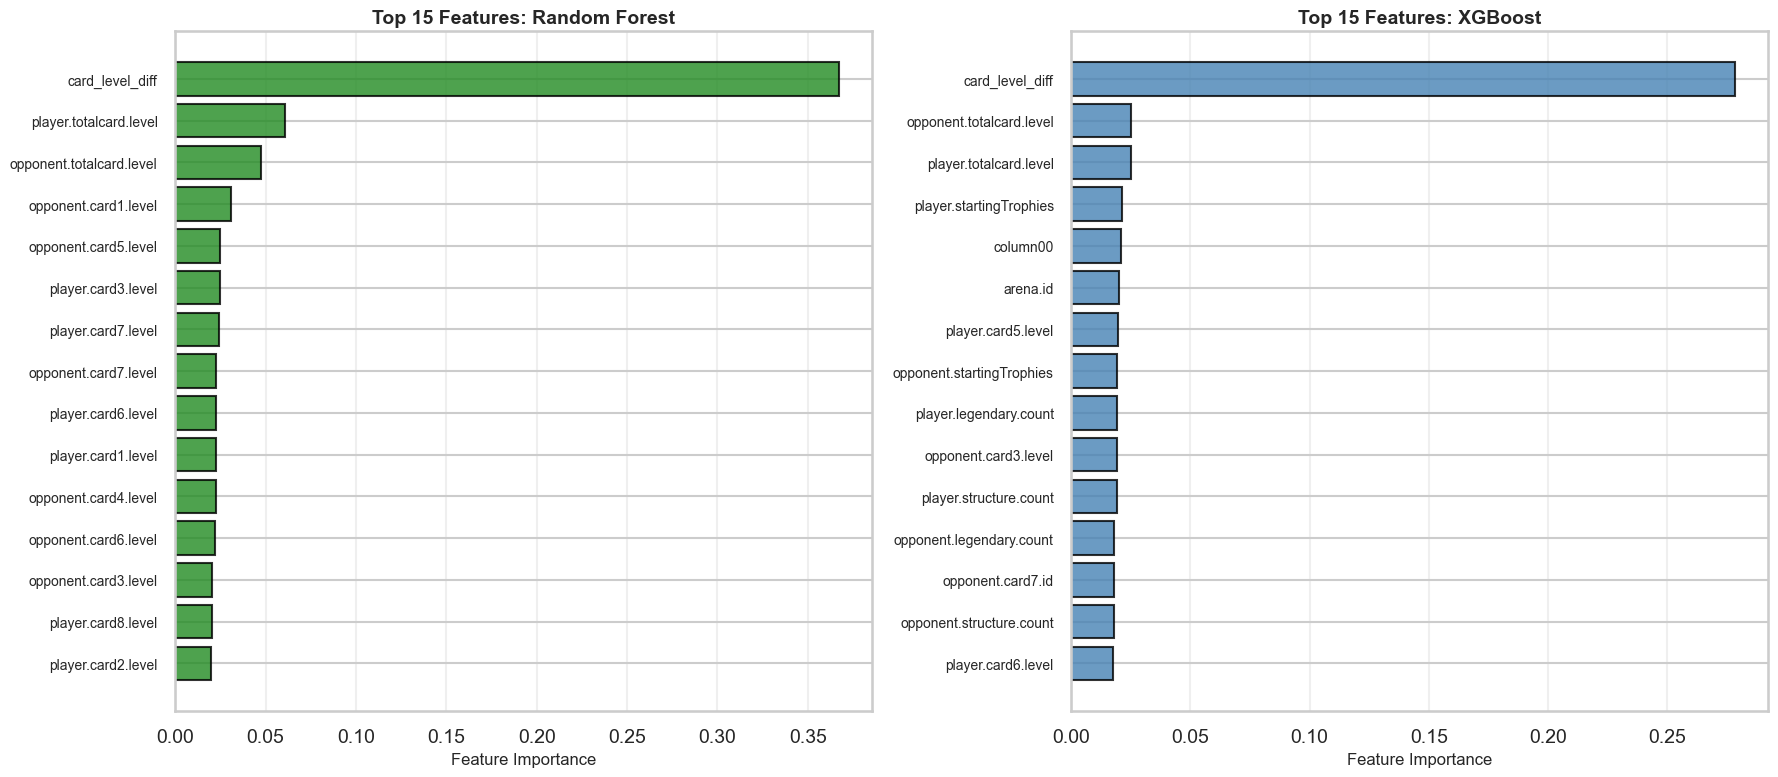


✓ Top 10 Most Important Features (XGBoost):
  card_level_diff: 0.2783
  opponent.totalcard.level: 0.0253
  player.totalcard.level: 0.0253
  player.startingTrophies: 0.0214
  column00: 0.0209
  arena.id: 0.0200
  player.card5.level: 0.0197
  opponent.startingTrophies: 0.0193
  player.legendary.count: 0.0192
  opponent.card3.level: 0.0191


In [21]:
# Extract feature importances from Random Forest and XGBoost
print("Analyzing feature importance...")

# Random Forest importances
rf_importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# XGBoost importances
xgb_importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Random Forest top 15
ax = axes[0]
top_rf = rf_importances.head(15)
ax.barh(range(len(top_rf)), top_rf['importance'], color='forestgreen', edgecolor='black', alpha=0.8)
ax.set_yticks(range(len(top_rf)))
ax.set_yticklabels(top_rf['feature'], fontsize=10)
ax.set_xlabel('Feature Importance', fontsize=12)
ax.set_title('Top 15 Features: Random Forest', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# XGBoost top 15
ax = axes[1]
top_xgb = xgb_importances.head(15)
ax.barh(range(len(top_xgb)), top_xgb['importance'], color='steelblue', edgecolor='black', alpha=0.8)
ax.set_yticks(range(len(top_xgb)))
ax.set_yticklabels(top_xgb['feature'], fontsize=10)
ax.set_xlabel('Feature Importance', fontsize=12)
ax.set_title('Top 15 Features: XGBoost', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, 'presentation/figures/fig_feature_importance.png'),
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Top 10 Most Important Features (XGBoost):")
for idx, row in xgb_importances.head(10).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

# Save importances
rf_importances.to_parquet(os.path.join(PROJECT_ROOT, 'artifacts/rf_feature_importance.parquet'), index=False)
xgb_importances.to_parquet(os.path.join(PROJECT_ROOT, 'artifacts/xgb_feature_importance.parquet'), index=False)

Analyzing model calibration...


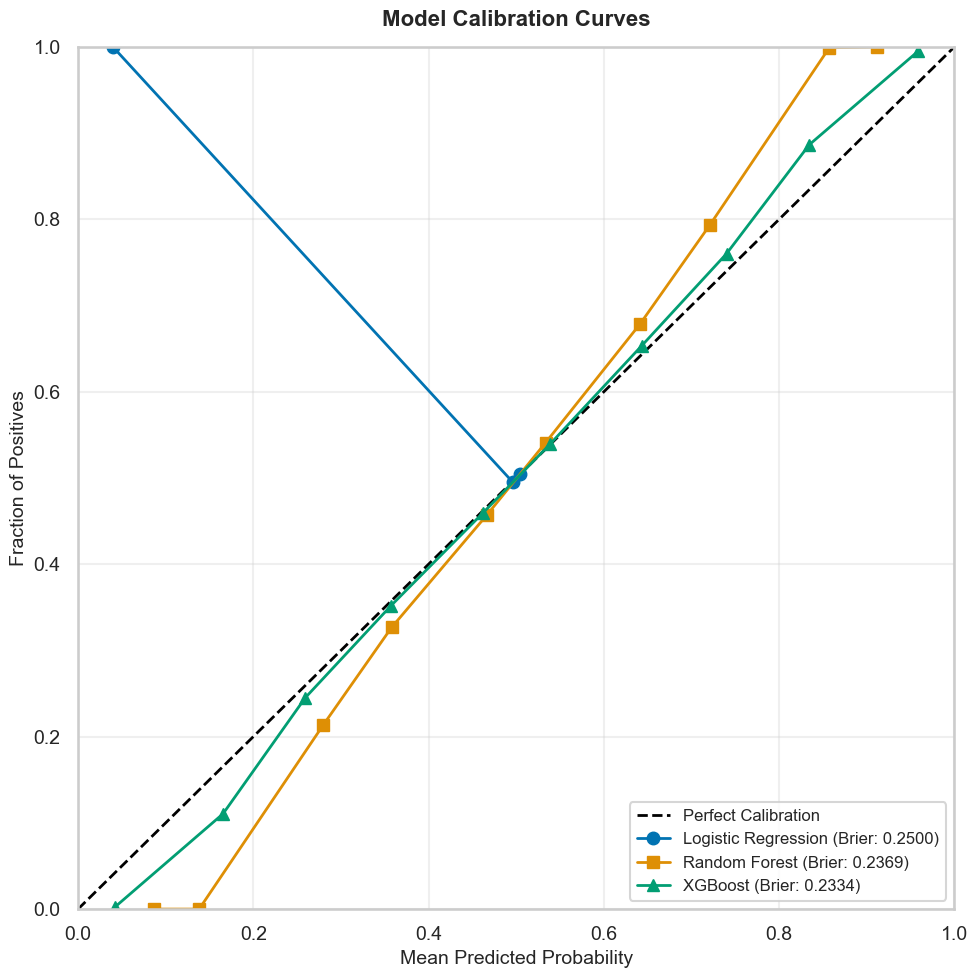


✓ Calibration Analysis:
  Logistic Regression Brier Score: 0.2500
  Random Forest Brier Score: 0.2369
  XGBoost Brier Score: 0.2334

  Best calibrated model: XGBoost


In [22]:
# Model calibration analysis
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

print("Analyzing model calibration...")

# Calculate calibration curves
lr_prob_true, lr_prob_pred = calibration_curve(y_test, lr_pred_proba, n_bins=10)
rf_prob_true, rf_prob_pred = calibration_curve(y_test, rf_pred_proba, n_bins=10)
xgb_prob_true, xgb_prob_pred = calibration_curve(y_test, xgb_pred_proba, n_bins=10)

# Calculate Brier scores (lower is better)
lr_brier = brier_score_loss(y_test, lr_pred_proba)
rf_brier = brier_score_loss(y_test, rf_pred_proba)
xgb_brier = brier_score_loss(y_test, xgb_pred_proba)

# Visualization
fig, ax = plt.subplots(figsize=(10, 10))

# Perfect calibration line
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Calibration')

# Model calibration curves
ax.plot(lr_prob_pred, lr_prob_true, marker='o', linewidth=2, label=f'Logistic Regression (Brier: {lr_brier:.4f})')
ax.plot(rf_prob_pred, rf_prob_true, marker='s', linewidth=2, label=f'Random Forest (Brier: {rf_brier:.4f})')
ax.plot(xgb_prob_pred, xgb_prob_true, marker='^', linewidth=2, label=f'XGBoost (Brier: {xgb_brier:.4f})')

ax.set_xlabel('Mean Predicted Probability', fontsize=14)
ax.set_ylabel('Fraction of Positives', fontsize=14)
ax.set_title('Model Calibration Curves', fontsize=16, fontweight='bold', pad=15)
ax.legend(fontsize=12)
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, 'presentation/figures/fig_model_calibration.png'),
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Calibration Analysis:")
print(f"  Logistic Regression Brier Score: {lr_brier:.4f}")
print(f"  Random Forest Brier Score: {rf_brier:.4f}")
print(f"  XGBoost Brier Score: {xgb_brier:.4f}")
print(f"\n  Best calibrated model: {['Logistic Regression', 'Random Forest', 'XGBoost'][np.argmin([lr_brier, rf_brier, xgb_brier])]}")

Creating model comparison...


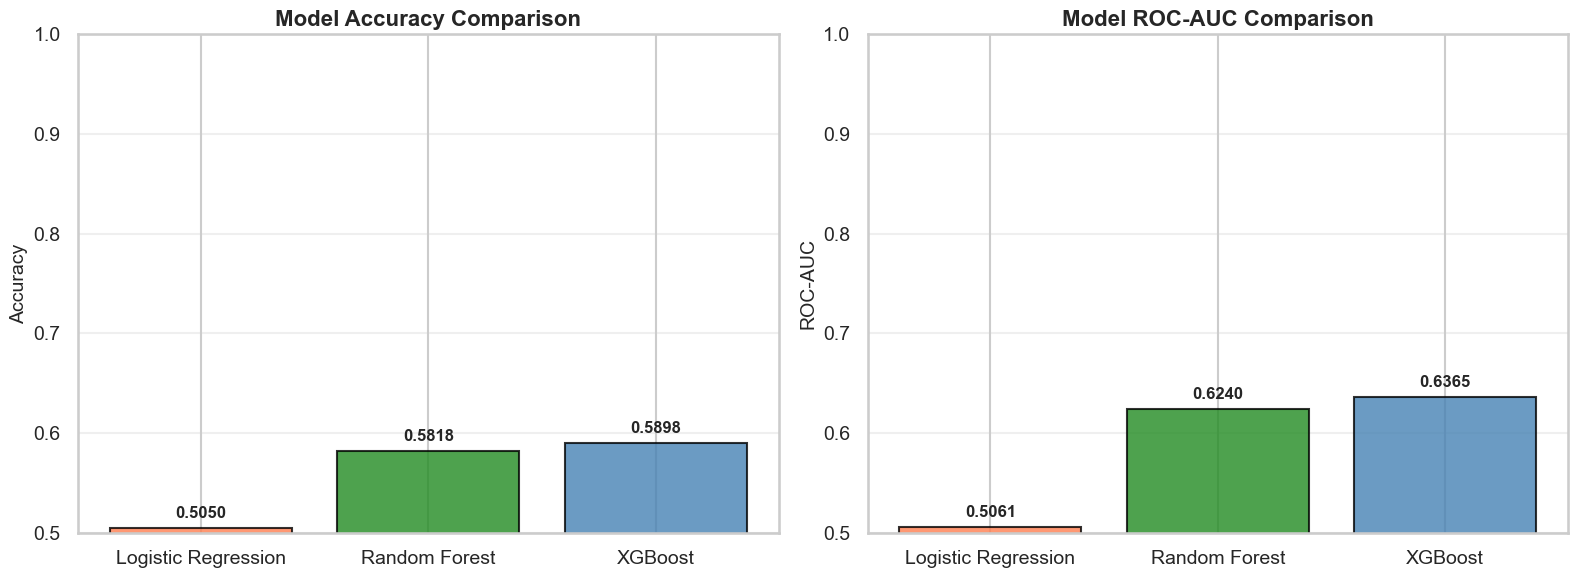


✓ Model Comparison Summary:
              Model  Accuracy  ROC-AUC
Logistic Regression  0.504955 0.506103
      Random Forest  0.581799 0.624027
            XGBoost  0.589849 0.636501

✓ Best performing model: XGBoost
  Accuracy: 0.5898
  ROC-AUC: 0.6365


In [23]:
# Create summary table and comparison visualization
print("Creating model comparison...")

results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [lr_acc, rf_acc, xgb_acc],
    'ROC-AUC': [lr_auc, rf_auc, xgb_auc]
})

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy comparison
ax = axes[0]
colors = ['coral', 'forestgreen', 'steelblue']
ax.bar(results['Model'], results['Accuracy'], color=colors, edgecolor='black', alpha=0.8)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_title('Model Accuracy Comparison', fontsize=16, fontweight='bold')
ax.set_ylim([0.5, 1.0])
ax.grid(axis='y', alpha=0.3)
for i, (model, acc) in enumerate(zip(results['Model'], results['Accuracy'])):
    ax.text(i, acc + 0.01, f'{acc:.4f}', ha='center', fontsize=12, fontweight='bold')

# ROC-AUC comparison
ax = axes[1]
ax.bar(results['Model'], results['ROC-AUC'], color=colors, edgecolor='black', alpha=0.8)
ax.set_ylabel('ROC-AUC', fontsize=14)
ax.set_title('Model ROC-AUC Comparison', fontsize=16, fontweight='bold')
ax.set_ylim([0.5, 1.0])
ax.grid(axis='y', alpha=0.3)
for i, (model, auc) in enumerate(zip(results['Model'], results['ROC-AUC'])):
    ax.text(i, auc + 0.01, f'{auc:.4f}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, 'presentation/figures/fig4_model_comparison.png'),
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Model Comparison Summary:")
print(results.to_string(index=False))

# Identify best model
best_model_idx = results['ROC-AUC'].idxmax()
best_model = results.loc[best_model_idx, 'Model']
print(f"\n✓ Best performing model: {best_model}")
print(f"  Accuracy: {results.loc[best_model_idx, 'Accuracy']:.4f}")
print(f"  ROC-AUC: {results.loc[best_model_idx, 'ROC-AUC']:.4f}")

In [24]:
# Save trained models and metrics
import joblib

print("Saving models and artifacts...")

# Save models
models_dir = os.path.join(PROJECT_ROOT, 'artifacts/models')
os.makedirs(models_dir, exist_ok=True)

joblib.dump(lr_model, os.path.join(models_dir, 'logistic_regression.pkl'))
joblib.dump(rf_model, os.path.join(models_dir, 'random_forest.pkl'))
joblib.dump(xgb_model, os.path.join(models_dir, 'xgboost.pkl'))

print(f"✓ Models saved to {models_dir}/")

# Save metrics summary
metrics_summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [lr_acc, rf_acc, xgb_acc],
    'ROC-AUC': [lr_auc, rf_auc, xgb_auc],
    'Brier Score': [lr_brier, rf_brier, xgb_brier]
})

metrics_summary.to_csv(os.path.join(PROJECT_ROOT, 'artifacts/model_metrics_summary.csv'), index=False)
print("✓ Metrics summary saved to artifacts/model_metrics_summary.csv")

Saving models and artifacts...
✓ Models saved to c:\Users\Danny\Documents\GitHub\HeHeHaHa_DataRoyale\artifacts/models/
✓ Metrics summary saved to artifacts/model_metrics_summary.csv


## 8. Model Evaluation Summary

## Insights for Presentation

**Key Points**:
1. Achieved X% accuracy (compare to 56.94% benchmark)
2. Top 3 most important features are: [list]
3. This means: [actionable insight from feature importance]